## Затронутые темы

Нейронаука:

- Вейвлеты Габора,
- визуальные восприимчивые поля
- простые / сложные ячейки (эксперимент Хьюбела и Визеля),
- кривая настройки
- Модели LNP
- сверточные модели

Python:

- numpy.mgrid/огрид
- matplotlib: imshow, контурные графики, штриховые графики
- области видимости, закрытия

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

В 1952 году Хьюбел и Визель сделали интересное открытие. Когда они ввели тонкие электроды в зрительную кору головного мозга кошки и представили маленькие пятна света на экране перед кошкой, некоторые клетки отреагировали, выпуская импульсы только тогда, когда пятно находилось в определенном положении. Одна и та же ячейка будет подавляться пятнами, расположенными в разных областях поля зрения, или она вообще не будет реагировать. Реакции таких нейронов полностью характеризовались тормозными и возбуждающими областями в поле зрения. Они назвали такие нейроны простыми клетками.

Они также обнаружили другой тип клеток, которые проявляли более сложные реакции. Эти клетки, называемые сложными клетками, реагировали только на визуальный объект определенной формы и ориентации, независимо от того, где он был расположен в поле зрения. Если изображение было слегка повернуто или его форма была изменена, ответ был подавлен.

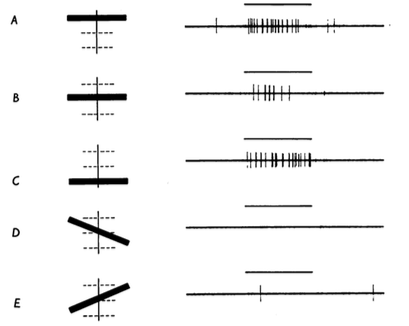

In [2]:
from IPython.display import Image
Image('images/hubel_wiesel_1962_fig7.png')

# Поля восприятия

Рецептивное поле - это набор стимулов, которые вызывают реакцию в отдельных нейронах. В случае зрительных рецептивных полей это участки света, пронизывающие сетчатку, которые наиболее эффективно управляют нейроном. Обычно визуальное рецептивное поле представляется в виде изображений, показывающих предпочтительные стимулы.

Теперь мы сгенерируем образец восприимчивого поля с помощью numpy. Начнем с периодического рисунка светлых и темных областей вдоль одной оси. Чтобы представить его в виде изображения, нам понадобится двумерная сетка из x и y координаты — по одной паре на пиксель — которые мы храним в двух массивах numpy XX и YY каждый из которых содержит только одну из координат. Это лучше всего иллюстрируется следующими схемами:

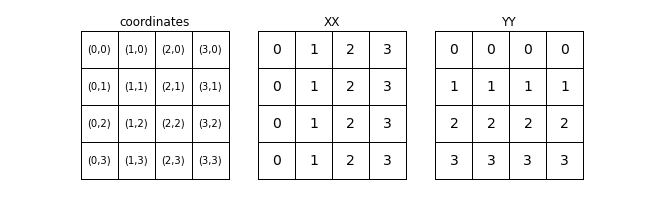

In [4]:
Image('images/meshgrid.png')

Обратите внимание, что значения в массивах XX и YY изменяются только по столбцам и строкам отдельно. Мы можем сгенерировать эти массивы, используя mgrid of numpy. При индексации среза подобно стандартному numpy array он возвращает массивы соответствующего формата. Например, чтобы получить двумерную сетку, в которой каждое измерение изменяется от -20 до 20 каждые 0,04, мы используем:

In [5]:
xmin, xmax, dx = -20, 20, 0.04 #степень
ymin, ymax, dy = -20, 20, 0.04

YY, XX = np.mgrid[xmin:xmax:dx, ymin:ymax:dy]

Теперь мы можем сгенерировать синусоидальный рисунок вдоль x измерения:

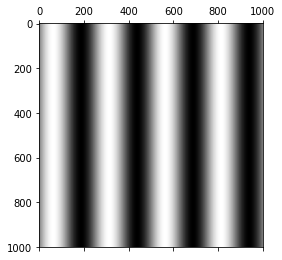

In [6]:
spatial_freq = 0.1
rf = np.sin(2 * np.pi * spatial_freq * XX)
plt.matshow(rf)
plt.gray()

Чтобы повернуть шаблон на заданный угол, мы можем преобразовать координаты, используя известное выражение для x и y во повернутой системе координат:

$$
yr = xcos (θ) + ysin(θ)=−xsin(θ) + ycos (θ)(1)(2)
$$

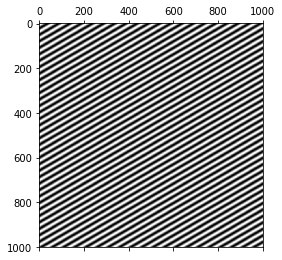

In [9]:
rf_angle = np.pi/3.

x_r = XX * np.cos(rf_angle)+YY*np.sin(rf_angle)
y_r=-XX*np.sin(rf_angle) + YY * np.cos(rf_angle)

rf = np.cos(2 * np.pi * spatial_freq * x_r)
plt.matshow(rf)
plt.gray()

Чтобы сделать восприимчивое поле ограниченным в пространстве, мы маскируем его гауссовой линией вдоль полос и прямоугольником поперек полос:

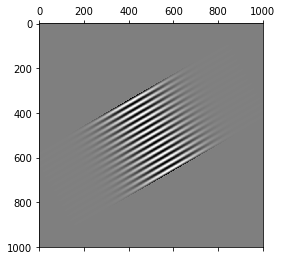

In [10]:
rf_height = 6.
rf_width = 7.5

mask_x = (np.abs(x_r) < rf_width)
mask_y = np.exp(-(y_r**2/rf_height**2))

rf *= mask_x * mask_y

plt.matshow(rf)

Поскольку мы собираемся генерировать поле восприятия довольно часто, мы можем определить его в функции:

In [11]:
def receptive_field(XX, YY, theta, width, height):
    x_r = XX * np.cos(theta) + YY * np.sin(theta)
    y_r = -XX * np.sin(theta) + YY * np.cos(theta)
    gaussian = np.exp(-np.pi*(y_r**2/height**2)) * (np.abs(x_r) < width)
    F = 1./width * 0.75
    complex_grating = np.exp(1j*2*np.pi*F*x_r)
    return gaussian * complex_grating.real

In [12]:
rf_height = 10
rf_width = 4
rf_angle = 0.
rf_ampl = 1. #Hz

W = rf_ampl * receptive_field(XX, YY, rf_angle, rf_width, rf_height)

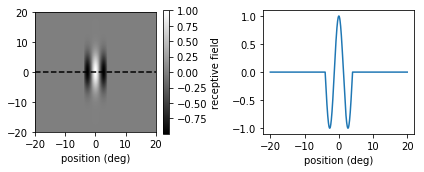

In [13]:
plt.figure(figsize=(6,2.5))
plt.subplot(121)
plt.imshow(W, extent=(xmin, xmax, xmin, xmax), aspect='equal')
plt.xlabel('position (deg)')

plt.axhline(0, ls='--', color='k')
plt.gray()
cbar = plt.colorbar()
plt.subplot(122)
plt.plot(XX[500,:], W[500, :])
plt.xlabel('position (deg)')
cbar.set_label('receptive field')
plt.tight_layout()

## Простая клетка

Теперь мы проанализируем реакцию простой ячейки с рецептивным полем, сгенерированным в предыдущем разделе, на белую полосу на черном фоне. Мы можем генерировать визуальный стимул таким же образом, как мы генерировали рецептивное поле:

In [14]:
def bar(XX, YY, length, width, angle):    
    x_r = XX * np.cos(angle) + YY * np.sin(angle)
    y_r = -XX * np.sin(angle) + YY * np.cos(angle)
    return  1 * (np.abs(x_r) < length / 2) * (np.abs(y_r) < width / 2)

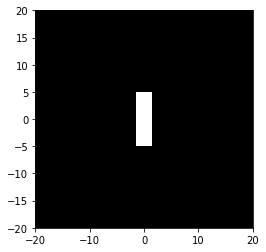

In [15]:
bar_length = 10.
bar_width = 3.
bar_angle = np.pi/2.
bar_lumosity = 1 
b = bar(XX, YY, bar_length, bar_width, bar_angle)
plt.imshow(b, extent=(xmin, xmax, ymin, ymax))
plt.gray()

Отклик отдельной ячейки пропорционален скалярному произведению поля восприятия $RF_{ij}$ с помощью стимула $S_{ij}$ или, другими словами, сумма по произведению пикселей обоих изображений:

$$
r_{simple}=[\sum\limits_{i}^{N_x} \sum\limits_{j}^{N_y} S_{ij}RF{ij} \Delta x \Delta y + r_{baseline}]_{+}
$$

Промежуточное исправление, обозначенное квадратными скобками с индексом "+" (таким, что [x]+=max(0,x)), был введен для поддержания скорости срабатывания простой ячейки строго положительной.

Поскольку нейрон не может генерировать отрицательные частоты срабатывания, для представления торможения мы вводим базовую частоту срабатывания rbaseline: частота срабатывания выше базовой означает возбуждение, в то время как частота срабатывания ниже базовой означает торможение.

Мы собираемся реализовать модели различных типов ячеек (сложных и простых), которые всегда будут принимать визуальный стимул (двумерный numpy массив) в качестве входных данных и выдавать на выходе отклик на частоту срабатывания (скаляр). Однако эти модели отличаются способом вычисления выходных данных на основе входных данных. Чтобы сделать эти модели пригодными для использования в аналогичном контексте, мы собираемся отделить эти детали реализации (поле приема и то, как оно используется для вычисления выходных данных) от интерфейса (входов и выходов). Это одна из основных концепций разработки программного обеспечения, называемая абстракцией.

Python предлагает несколько способов получения этой абстракции, одним из которых являются замыкания. Замыкание - это функция с некоторым внешним состоянием. Это реализовано с помощью вложенной функции (функция, определенная внутри функции). Каждая функция определяет свою собственную область действия (блок кода, в котором доступны определяемые переменные), но также имеет доступ к переменным в области действия функции, расположенной выше в иерархии вложенности. Мы будем использовать эту область для хранения (статических) переменных состояния для вложенной функции.

Вот реализация:

In [17]:
def rectify(x):
    return x * (x > 0)

def simple_cell_model(receptive_field, baseline_rate, dxy):
    dx, dy = dxy
    def _response(stim):
        r = np.sum(stim * receptive_field) * dx * dy + baseline_rate
        return rectify(r)
    return _response

Комментарии:

- L4: функция переноса принимает два аргумента, которые мы позже будем использовать для вычисления отклика простой ячейки. Эти два аргумента определяют состояние ячейки.

- L6-8: определение вложенной функции. Эта функция принимает дополнительный аргумент, визуальный стимул, но у нее также есть доступ к receptive_field и baseline_rate переменным заключающей функции.

- L9: заключающая функция возвращает вложенную функцию. В Python функции являются "гражданами первого класса", что означает, что они могут быть назначены переменным, возвращены и т.д. как и любой другой объект. Обратите внимание, что возвращаемая функция сохранит переменные в области действия заключающей функции (receptive_field и baseline_rate) даже после завершения функции.

Чтобы определить новую ячейку, мы вызываем вышеупомянутую функцию с двумя аргументами: поле приема (двумерный массив) и базовая частота срабатывания:

In [18]:
baseline_rate = 20
simple_cell = simple_cell_model(W, 20, (dx, dy)) 

Теперь мы можем рассчитать реакцию на стимул bar, который мы определили ранее:

In [19]:
r = simple_cell(b)
print("Output firing rate: {:.1f} Hz".format(r))
print("Change from baseline: {:.1f} Hz".format(r - baseline_rate))

Output firing rate: 33.1 Hz
Change from baseline: 13.1 Hz


Давайте теперь посмотрим на реакцию этой простой ячейки на две полосы, сдвинутые относительно друг друга в x координате:

Text(0,0.5,'longlitude (deg)')

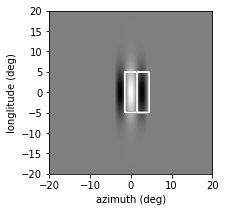

In [20]:
plt.figure(figsize=(3, 3))
plt.imshow(W, extent=(xmin, xmax, ymin, ymax))
b1 = bar(XX, YY, bar_length, bar_width, bar_angle)
b2 = bar(XX - bar_width, YY, bar_length, bar_width, bar_angle)
plt.contour(XX[0,:], YY[:,0 ],b1)
plt.contour(XX[0,:], YY[:,0], b2)
plt.xlabel('azimuth (deg)')
plt.ylabel('longlitude (deg)')

Две полосы наложены на область восприятия с помощью белых линий. Для их построения мы использовали contour график из matplotlib библиотеки, который показывает контурные линии постоянных уровней на двумерной карте.

Давайте сравним реакции этого простого нейрона на презентации каждого столбца в отдельности (столбцы 1 и 2), сумму ответов и реакцию на оба столбца, представленные вместе (столбец 1 + 2). Поскольку нас интересует только изменение базовой скорости стрельбы, сначала мы вычитаем базовую.

Text(0,0.5,'change of firing rate (Hz)')

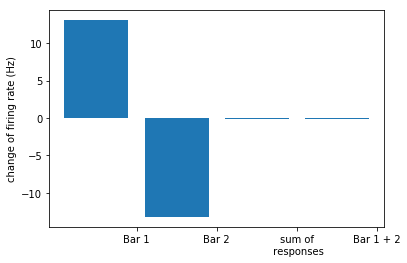

In [21]:
r1 = simple_cell(b1) - baseline_rate
r2 = simple_cell(b2) - baseline_rate
r1and2 = simple_cell(b1 + b2) - baseline_rate
plt.bar(range(4), [r1, r2, r1+r2, r1and2])
plt.xticks(np.arange(4) + 0.5, ["Bar 1", "Bar 2", "sum of\n responses", "Bar 1 + 2"])
plt.ylabel('change of firing rate (Hz)')

Полоса 1 воздействовала на возбуждающую часть рецептивного поля, что приводило к увеличению скорости срабатывания. На тормозящей части рецептивного поля появилась полоса 2, что привело к снижению скорости срабатывания. Ответы на эти столбцы противодействовали друг другу, поэтому, когда ответы были суммированы вместе, итогового изменения в общей частоте срабатывания не произошло. Важно, что при одновременном представлении столбцов отклик был равен отклику, полученному путем суммирования ответов на отдельные столбцы. Это следствие линейности простой ячейки: реакция на визуальный стимул равна сумме ответов на ее части. Этот факт был использован Хьюбелом А.н. Визелем для составления карты рецептивного поля простых клеток посредством реакции на маленькие точки света.

## Настройка положения и ориентации

Другой способ охарактеризовать реакции нейронов зрительной коры на набор стимулов - построить так называемые кривые настройки. Кривая настройки описывает реакцию нейрона на плавное изменение одного параметра, характеризующего стимул, такого как его положение вдоль одной из осей, угол наклона или размер.

Давайте начнем с настройки ориентации, которая суммирует реакции на изменение угла стимула. Мы определяем функцию, которая принимает функцию, вычисляющую скорость срабатывания для данного стимула, в качестве единственного аргумента. Для стимула мы повторно используем полосу, которую определили ранее, и меняем ее угол наклона.

In [22]:
def orientation_tuning(response_func):
    responses = []
    thetas = np.linspace(-np.pi, np.pi, 100)
    for theta in thetas:
        b = bar(XX, YY, bar_length, bar_width, theta)
        r = response_func(b)
        responses.append(r)
    responses = np.array(responses)
    return thetas, responses

Реакция отдельной ячейки на столбцы различной ориентации является периодической с максимумом для вертикально ориентированных столбцов (θ=kπ/2 для k=1,2,..):

Text(0,0.5,'firing rate (Hz)')

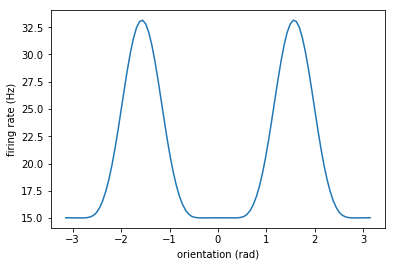

In [23]:
thetas, responses = orientation_tuning(simple_cell)
plt.plot(thetas, responses)
plt.xlabel('orientation (rad)')
plt.ylabel('firing rate (Hz)')

Аналогичным образом, мы можем анализировать изменения скорострельность в вариации установки в баре, так называемый тюнинг ориентация .

In [26]:
def position_tuning(response_func):
    xcoords = np.linspace(-10, 10, 100)
    responses = []
    for x0 in xcoords:
        b = bar(XX - x0, YY, bar_length, bar_width, bar_angle)
        r = response_func(b)
        responses.append(r)
    responses=np.array(responses)
    return xcoords, responses

Text(0,0.5,'firing rate (Hz)')

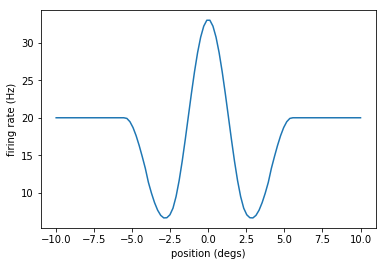

In [27]:
xcoords, responses = position_tuning(simple_cell)
plt.plot(xcoords, responses)
plt.xlabel('position (degs)')
plt.ylabel('firing rate (Hz)')

## Сложная клетка

Теперь мы переходим к моделированию сложной ячейки. Как я уже упоминал, сложные ячейки реагируют на объект определенного размера и формы независимо от того, где он конкретно расположен в пределах его восприимчивого поля. С технической точки зрения это вызов инвариантность перевода.

Сначала мы определяем функцию для вычисления реакции сложной ячейки на данный стимул. Снова мы собираемся использовать замыкание. Функция свертки принимает единственный аргумент, который представляет собой список простых ячеек. Вложенная функция просто перебирает все эти ячейки и суммирует их ответы:

In [28]:
def complex_cell_model(simple_cells):    
    def _response(stim):
        response = 0
        for inp in simple_cells:
            response += (inp(stim))
        return response 
    return _response

Чтобы создать новую сложную ячейку, сначала мы определяем список простых ячеек, которые все имеют одинаковую форму поля восприятия, но переведены относительно друг друга:

In [29]:
x_rf = np.arange(-8, 8, 1) #linspace(-8, 8, 17)
Ws = [receptive_field(XX - x0, YY, rf_angle, rf_width, rf_height) for x0 in x_rf]
simple_cells = [simple_cell_model(rf, 0, (dx, dy)) for rf in Ws]

Мы можем построить рецептивные поля, используя контурные графики для возбуждающих (красный) и тормозящих (синий) доменов:

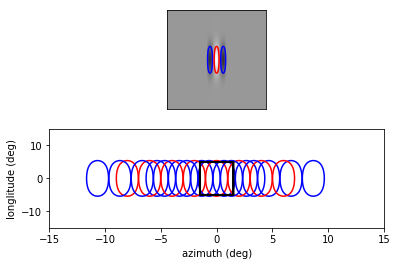

In [30]:
plt.subplot(211)
plt.imshow(W, extent=(xmin, xmax, ymin, ymax), alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.gray()
plt.contour(XX[0,:], YY[:,0], W, [-0.4, 0.4], colors=['b', 'r'])

plt.subplot(212)
for w in Ws[::2]:
    plt.contour(XX[0, :], YY[:, 0], w, [-0.4, 0.4], colors=['b', 'r'])
plt.ylim([-15, 15])
plt.xlim([-15, 15])
plt.xlabel('azimuth (deg)')
plt.ylabel('longlitude (deg)')
plt.contour(XX[0,:], YY[:,0], b1, colors=['k'])

Как вы можете видеть, тормозные и возбуждающие домены в рецептивных полях разных нейронов накладываются друг на друга (для сравнения размеров я добавил полосу выборки черного цвета). Это необходимо для обеспечения трансляционной инвариантности. Теперь давайте смоделируем сложную ячейку, суммирующую ответы от так определенных простых ячеек, и построим график настройки ее положения:

In [31]:
complex_cell = complex_cell_model(simple_cells)

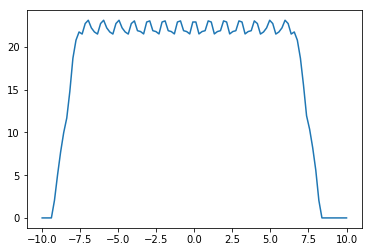

In [32]:
xcoords, responses = position_tuning(complex_cell)
plt.plot(xcoords, responses)

Обратите внимание, что отклик высок везде, где полоса расположена в пределах воспринимающего поля, и падает только по бокам воспринимающего поля.

Настройка ориентации очень похожа на настройку простой ячейки, включая максимумы, кратные π/2:

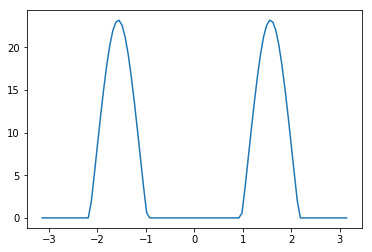

In [33]:
thetas, responses = orientation_tuning(complex_cell)
plt.plot(thetas, responses)

Интересное свойство сложной ячейки заключается в том, что ответ на сумму двух столбцов не обязательно является суммой ответов на один столбец. Давайте представим стимулы в виде двух полос, которые мы определили ранее, чтобы охарактеризовать реакции простой ячейки.

Text(0.5,1,'two stimulation bars superposed on\na sample simple cell RF')

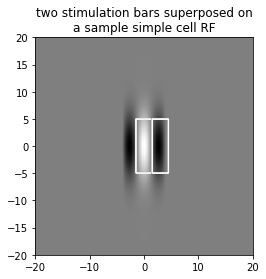

In [34]:
plt.imshow(W, extent=(xmin, xmax, ymin, ymax))
plt.contour(XX[0,:], YY[:,0], b1)
plt.contour(XX[0,:], YY[:,0], b2)
plt.title('two stimulation bars superposed on\na sample simple cell RF')

Когда одна часть полосы попадает на возбуждающий домен, а другая - на тормозящий домен простой клетки, ее реакция может не измениться ("Полоса 1 + 2" ниже). Однако, когда мы представляем столбцы по отдельности, каждый из них может активировать другую простую ячейку, предоставляя ввод в сложную ячейку, так что общий отклик будет представлять собой сумму откликов этих простых ячеек (столбец "Сумма ответов"). Такое поведение возможно только из-за выпрямляющей нелинейности в выходных данных простой ячейки и, следует отметить, может быть получено с помощью линейной модели.

Text(0.5,1,'complex cell responses')

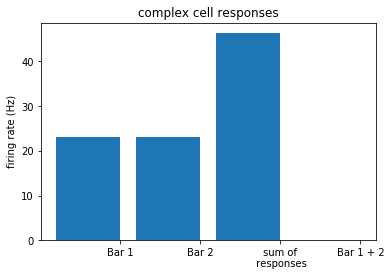

In [35]:
r1 = complex_cell(b1)
r2 = complex_cell(b2)
r1and2 = complex_cell(b1 + b2)
plt.bar(range(4), [r1, r2, r1+r2, r1and2])
plt.xticks(np.arange(4) + 0.4, ["Bar 1", "Bar 2", "sum of\n responses", "Bar 1 + 2"])
plt.ylabel('firing rate (Hz)')
plt.title('complex cell responses')

## Ретинотопия

В примере со сложными ячейками мы рассмотрели ситуацию, когда простые ячейки с преобразованными рецептивными полями покрывают область поля зрения. Фактически, это общая архитектурная особенность коры головного мозга: один и тот же тип ответов распределен по большей сенсорной области. В зрительной коре такое отображение называется ретинотопией, в соматосенсорной коре (кодирующей кожные ощущения, такие как прикосновение и боль) оно называется соматотопией, а в слуховой коре, где сенсорное пространство является доминирующей частотой слухового сигнала, - тонотопией.

Каждая позиция на карте представлена отдельной ячейкой или группой ячеек с полем восприятия, центрированным в этой позиции. Мы можем проиллюстрировать эту идею на простом примере: на рисунке ниже карта показана в виде сетки, и каждое изображение в сетке представляет собой восприимчивое поле ячейки в соответствующем местоположении на карте.

<Figure size 432x432 with 0 Axes>

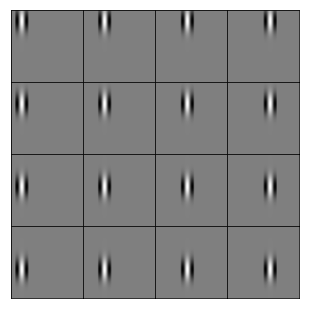

In [36]:
plt.figure(figsize=(6,6))
n_grid = 4
fig, axes = plt.subplots(n_grid,n_grid, 
                         figsize=(4,4),
                         gridspec_kw=dict(hspace=0,
                                          wspace=0,
                                          left=0,
                                          right=1,
                                          bottom=0,
                                          top=1))
delta_x0 = (xmax - xmin)/(n_grid + 2)
delta_y0 = (ymax - ymin)/(n_grid + 2)

for i in range(n_grid):
    for j in range(n_grid):
        ax = axes[j, i]
        x0, y0 = xmax - (i+1) * delta_x0, ymax - (j + 1) * delta_y0
        rf = receptive_field(XX + x0, YY + y0 , rf_angle, rf_width, rf_height)
        ax.imshow(rf)
        ax.set_xticks([])
        ax.set_yticks([])

Математически умножение входного изображения на каждое из вышеупомянутых полей восприятия для получения карты ответов эквивалентно двумерной свертке. Ограничение заключается в том, что в каждой позиции поле восприятия должно быть идентичным, но взамен это дает большое вычислительное преимущество.

В качестве примера мы рассчитаем карту откликов простых ячеек на это изображение:

In [37]:
R = 3
dR = 1
XX, YY = np.ogrid[-20:20:800j,-20:20:800j]
r = np.sqrt(XX**2+YY**2)
im = (((r % R) > 0) * ((r % R) < dR)).astype('u1')

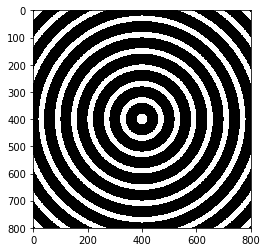

In [38]:
plt.imshow(im)
plt.gray()

Из-за вычислительных затрат мы уменьшим размер (понижающую выборку) поля восприятия, используемого ранее, и отрегулируем размер поля восприятия в соответствии с пространственными частотами на изображении:

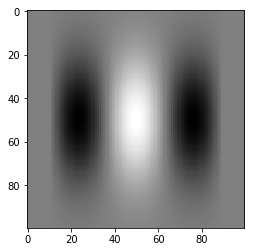

In [39]:
YY_ds, XX_ds = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
rf_width_ds = rf_width * 4
rf_height_ds = rf_height * 2
W_ds = rf_ampl * receptive_field(XX_ds, YY_ds, rf_angle, rf_width_ds, rf_height_ds)
plt.imshow(W_ds, interpolation='nearest')
plt.gray()

Двумерная свертка осуществляется в signal модуль scipy пакет:

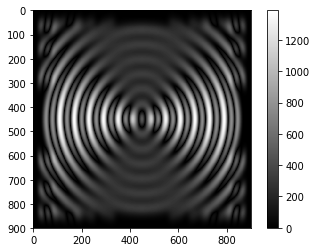

In [40]:
from scipy import signal
def simple_cell_map(im, W):
    conv = signal.convolve2d(im, W)
    map_response = rectify(conv) + rectify(-conv)
    return map_response
map_response = simple_cell_map(im, W_ds)
plt.imshow(map_response)
plt.colorbar()

Аналогично отклику простой ячейки мы использовали функцию rectify для обеспечения положительной частоты срабатывания. Дополнительно мы суммировали отклик с откликом простой ячейки с отрицательным рецептивным полем. Этот маленький трюк позволяет нам составить карту ориентации объектов изображения, независимо от их яркости ("белое на черном фоне" или "черное на белом фоне").

Теперь мы можем комбинировать ответы на восприимчивые поля под углом $0$, $\frac{π}{4}$, $\frac{π}{2}$ и $\frac{3π}{4}$ использование векторного суммирования:

$$
\varphi(x, y)=\sum \theta r \theta (x, y)e2i\theta
$$

где $r\theta$ это реакция клетки с рецептивным полем, ориентированным под углом $\theta$.

In [41]:
phi = 0
thetas = np.linspace(0, np.pi, 4)[:-1]
for theta in thetas:
    W_ds = receptive_field(XX_ds, YY_ds, theta, rf_width_ds, rf_height_ds)
    c = simple_cell_map(im, W_ds)
    phi = phi + c * np.exp(2j*theta)

Мы принимаем угол наклона вектора в комплексной плоскости за предполагаемую локальную ориентацию на изображении:

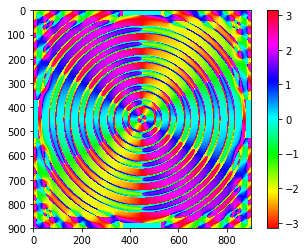

In [42]:
angles = np.angle(phi)
plt.imshow(angles)
plt.hsv()
plt.colorbar()